<img src="https://api.immobilienscout24.de/content/dam/is24/images/api/api-logo-immobilienscout24_250x50_font_blau.png" alt="In Zusammenarbeit mit Immobilienscout24.de">

# Crawl real estate data from Immobilienscout24.de

Notes
* The SEARCH API will be used
* API permission was granted because data will be used for a student project


*API Documentation: https://api.immobilienscout24.de/*

## Setup

In [1]:
import pandas as pd
import numpy as np
from xml.etree import ElementTree
import getpass

import requests
from requests_oauthlib import OAuth1

# define path where output file should be exported to
#CB: 
#path_op = '/Users/cbineyti/Library/Mobile Documents/com~apple~CloudDocs/Docs/40_DataScience/80_Ironhack/30_Testing/IS24/'

# auth information obtained from IS24
client_key = 'immokb24_contentKey'
client_secret = getpass.getpass() 

base_url = 'https://rest.immobilienscout24.de/restapi/api/search/v1.0/search/region'

auth = OAuth1(client_key, client_secret)  # , 'USER_OAUTH_TOKEN', 'USER_OAUTH_TOKEN_SECRET')


········


Notebook display settings:

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 7000
pd.options.display.max_colwidth = 200

## Set parameters for different requests 

In [3]:
# real estate objects to buy IN GERMANY
params_de = { 
    'realestatetype':'apartmentbuy', 
    'geocodes': 1276
}

# real estate objects to buy IN ESSEN
params_essen = {
    'realestatetype':'apartmentbuy', 
    'geocodes': 1276010015
}

# ... Berlin
params_bln = {
    'realestatetype':'apartmentbuy', 
    'geocodes': 1276003001
}

params_ham = {
    'realestatetype':'apartmentbuy', 
    'geocodes': 1276006001 
}


## Execute requests

In [4]:
# Germany
resp_de = requests.get(base_url, auth=auth, params=params_de)

In [5]:
# Essen
resp_essen = requests.get(base_url, auth=auth, params=params_essen)

In [6]:
# Berlin
resp_bln = requests.get(base_url, auth=auth, params=params_bln)

In [7]:
# Hamburg
resp_ham = requests.get(base_url, auth=auth, params=params_ham)

In [8]:
#print(resp_de.text)

In [9]:
#print(resp_essen.text)

In [10]:
#print(resp_bln.text)

# Read XML into Dataframe

#### Read XML output into Element Tree root

In [11]:
root_de = ElementTree.fromstring(resp_de.content)

In [12]:
root_essen = ElementTree.fromstring(resp_essen.content)

# Extract information from one page

#### Define function to get information from a root into a dictionary
* Input: root
* Output: dictionary

### <font color="red">USE YIELD / recursiv function</font>

In [13]:
# Define function to get information from a root into a dictionary
def get_xml_data(root):
    
    # define lists for each field that will be extracted
    lst_realEstateId = []
    lst_titles = []
    lst_cities = []
    lst_quarters = []
    lst_prices = []
    lst_livingSpace = []
    lst_rooms = []
    lst_num_pages = []

    # loop through the real estate entries and save information into lists
    for child in root[1]:
        lst_realEstateId.append(child.find('realEstateId').text)
        lst_titles.append(child[3].find('title').text)
        lst_cities.append(child[3][1].find('city').text)
        lst_quarters.append(child[3][1].find('quarter').text)
        lst_prices.append(child[3].find('price')[0].text)
        lst_livingSpace.append(child[3].find('livingSpace').text)
        lst_rooms.append(child[3].find('numberOfRooms').text) 
        lst_num_pages.append(root[0].find('pageNumber').text)

    # create dictionary from lists above
    dict_lsts = {'id': lst_realEstateId,
                 'title': lst_titles,
                 'city': lst_cities,
                 'quarter': lst_quarters,
                 'price': lst_prices,
                 'qm': lst_livingSpace,
                 'n_room': lst_rooms,
                 'n_page': lst_num_pages
                }
    
    return dict_lsts

#### Test the function `get_xml_data`

In [14]:
df_essen = pd.DataFrame(get_xml_data(root_essen)).assign(is24_page=1)


In [111]:
df_essen;

#### Test the function in a loop

In [16]:
for i in range(3):
    df_essen = df_essen.append(pd.DataFrame(get_xml_data(root_essen)).assign(is24_page=i+2))

In [112]:
df_essen.reset_index(drop=True);

# Loop over all pages of the response (XML) 

Steps:

* define a function that returns a dataframe based on a URL
* define a function that returns the number of pages based on a URL
* loop over all pages of an XML response and concatinate all output into one dataframe

#### Function to get a dataframe based on a URL

In [18]:
def df_from_url(url, params):  
    # send the get request using global auth information and provided url and params
    global auth
    resp = requests.get(url, auth=auth, params=params)
    
    # get XML response into the root of an ElementTree
    root = ElementTree.fromstring(resp.content)
    
    # call get_xml_data function to store information into a dataframe
    df = pd.DataFrame(get_xml_data(root))
    
    return df


#### Function to get the number of pages based on a URL

In [19]:
def num_pages_from_url(url, params):  
    
    # send the get request using global auth information and provided url and params
    global auth
    resp = requests.get(url, auth=auth, params=params)
    
    # get XML response into the root of an ElementTree
    root = ElementTree.fromstring(resp.content)
    
    # navigate to the number of pages and get the text
    num_pages = int(root[0].find('numberOfPages').text)
    
    return num_pages


#### Test `num_pages_from_url` function

In [20]:
num_pages_de = num_pages_from_url(base_url, params_de)
num_pages_de

2264

#### Test `df_from_url` function

In [21]:
df_essen = df_from_url(base_url, params_essen)


In [22]:
params_essen

{'realestatetype': 'apartmentbuy', 'geocodes': 1276010015}

In [113]:
df_essen;

### Create `df_essen`

#### Steps:

* create `df_essen` with first page of response
* loop over all other pages and append dataframe built from each page to the existing dataframe

In [24]:
df_essen = df_from_url(base_url, params_essen)

for i in range(2, num_pages_from_url(base_url, params_essen) + 1):
    params_essen_loop = { 
        'realestatetype':'apartmentbuy', 
        'geocodes': 1276010015,
        'pagenumber': i
    }
    df_essen = df_essen.append(df_from_url(base_url, params_essen_loop))

### Write function to create concatenated dataframe

#### Define dictionary with location name (city or country or region, ...) and corresponding geocodes

The geocodes can be obtained using the GIS API from api.immobilienscout24.de

In [25]:
di_locations = {
    'deutschland': 1276,
    'berlin': 1276003001,
    'essen': 1276010015,
    'hamburg': 1276006001
}

test dictionary...

In [26]:
location = 'essen'

In [114]:
di_locations[location];

In [115]:
di_locations;

#### Define function to create entire dataframe for a location

In [84]:
def create_df_all(url, location, di_locations):
    
    params_loc = { 
        'realestatetype':'apartmentbuy', 
        'geocodes': di_locations[location]
    }
    
    df_location = df_from_url(url, params_loc)
    
    for i in range(2, num_pages_from_url(url, params_loc) + 1):
        params_loc_loop = { 
            'realestatetype':'apartmentbuy', 
            'geocodes': di_locations[location],
            'pagenumber': i
        }
        df_location = df_location.append(df_from_url(url, params_loc_loop))
    
    return df_location

### Calculate additional columns

#### Calculate price per qm in new column `price_per_qm`

In [30]:
df_essen['price'] = pd.to_numeric(df_essen['price'])
df_essen['qm'] = pd.to_numeric(df_essen['qm'])
df_essen['price_per_qm'] = round(df_essen['price'] / df_essen['qm'], 1)

#### Add column `zwangsversteigerung` to indicate whether the listed item is a Zwangsversteigerung

*Note: this piece of information is not reliable*

In [31]:
df_essen['zwangsversteigerung'] = np.where(df_essen['title'].str.contains('Zwangs'), 'yes', 'no')

#### Reset index and sort dataframe by price per qm

In [32]:
df_essen_op = df_essen.reset_index(drop=True).sort_values(by='price_per_qm')

# Output `df_essen` to CSV file

In [116]:
df_essen_op;

In [34]:
# df_essen_op.to_csv(path_op + 'essen_v0.1.csv', index=False)

# EDA

In [35]:
df = df_essen_op.copy()

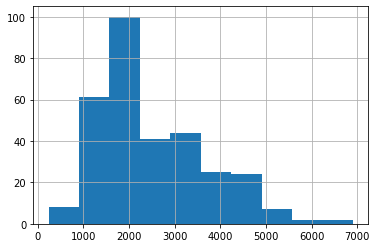

In [36]:
df.price_per_qm.hist();

---

# Create Berlin dataframe `df_berlin`

Steps:

* Run `create_df_all` to create dataframe containing all information (i.e. all pages) for Berlin
* Calculate the `price_per_qm`
* Save output to csv file

In [85]:
df_berlin = create_df_all(base_url, 'berlin', di_locations).reset_index(drop=True)

In [38]:
df_hamburg = create_df_all(base_url, 'hamburg', di_locations).reset_index(drop=True)

### Load CBs Berlin dataframe for comparison

In [39]:
df_berlin_cb = pd.read_csv("20200122_apts_buy_berlin_v0.1_CB.csv", encoding='utf8', engine='python')

In [79]:
df_berlin_ag = pd.read_csv("20200122_apts_buy_berlin_v0.2_AG.csv", encoding='utf8', engine='python')

In [92]:
df_berlin_ag_test = pd.read_csv("20200122_apts_buy_berlin_v0.2_AG_test.csv", encoding='utf8', engine='python')

### Data Wrangling

In [86]:
df_berlin[["id"]].astype(int);

In [87]:
df_essen[["id"]].astype(int);

In [88]:
df_hamburg[["id"]].astype(int);

In [89]:
df_berlin_ag[["id"]].astype(int);

In [94]:
df_berlin_ag_test[["id"]].astype(int);

In [110]:
df_berlin_cb[df_berlin_cb["id"].str.isdigit().fillna(False) == False]

Unnamed: 0      id  \
1839     bezugsfreie 4-Zimmer-Wohnung im sichersten Kiez  Berlin   
2252                               in Berlin - Grunewald  Berlin   
2498                                                 NaN  Berlin   
2500                                                 NaN  Berlin   
2511                       Kapitalanlage im Stephan-Kiez  Berlin   
3031                         -Bezugsfrei zum 31.11.2021-  Berlin   
3034   -Hier ist einiges möglich und das Provisionsfrei-  Berlin   
3719                         -Bezugsfrei zum 31.11.2021-  Berlin   
4314  -Barrierefreie Terrassenwohnung am Bundesratufer -    None   
4315                                                 NaN  Berlin   
6067                             MITTE-VIERZIMMERWOHNUNG    None   
6068                               MIT BALKON+STELLPLATZ  Berlin   

                            title      city quarter  price     qm  n_room  \
1839          Steglitz (Steglitz)  499000.0    90.0    4.0   92.0  5544.4   
2252  Schmargendorf (Wilmersdorf)  295000.0    70.0    2.5  113.0  4214.3   
2498      Tiergarten (Tiergarten)  749000.0   117.0    3.0  125.0  6401.7   
2500      Tiergarten (Tiergarten)  749000.0   117.0    3.0  125.0  6401.7   
2511      Tiergarten (Tiergarten)  866000.0   252.0    8.0  126.0  3436.5   
3031      Tiergarten (Tiergarten)  695000.0   145.0    5.0  152.0  4793.1   
3034      Tiergarten (Tiergarten)  135000.0    26.0    1.0  152.0  5192.3   
3719      Tiergarten (Tiergarten)  695000.0   145.0    6.0  186.0  4793.1   
4314                         None      None    None    NaN    NaN     NaN   
4315      Tiergarten (Tiergarten)  209000.0    45.0    2.0  216.0  4644.4   
6067                         None      None    None    NaN    NaN     NaN   
6068      Tiergarten (Tiergarten)  449000.0    95.0    4.0  303.0  4726.3   

      n_page  price_per_qm  
1839     NaN           NaN  
2252     NaN           NaN  
2498     NaN           NaN  
2500     NaN           NaN  
2511     NaN           NaN  
3031     NaN           NaN  
3034     NaN           NaN  
3719     NaN           NaN  
4314     NaN           NaN  
4315     NaN           NaN  
6067     NaN           NaN  
6068     NaN           NaN

In [90]:
df_berlin_cb[["id"]].astype(int);

ValueError: invalid literal for int() with base 10: 'Berlin'

In [60]:
df_hamburg.head(1000)

id  \
0    114967171   
1    114780936   
2    112110309   
3    112110281   
4    110377467   
5    110377476   
6    112262609   
7    112279052   
8    115091948   
9    108374061   
10   115170121   
11   115270162   
12   113663908   
13   110377487   
14   109748644   
15   114912992   
16   114706974   
17   114706971   
18   114706970   
19   114706967   
20   114706965   
21   114706963   
22   114706962   
23   114706961   
24   114706958   
25   114706957   
26   114706956   
27   111554162   
28   111541271   
29   114458636   
30   114458597   
31   114458550   
32   114458543   
33   114458508   
34   114458371   
35   114458323   
36   114002938   
37   114001345   
38   115420018   
39   115419968   
40   113885400   
41   113877048   
42   113885227   
43   115371413   
44   115241953   
45   115241951   
46   115241848   
47   115241844   
48   113428459   
49   113132510   
50   110912198   
51   110894314   
52   110891423   
53   106657856   
54   102507277   
55   114509524   
56   113918296   
57   113917506   
58   112262630   
59   112262626   
60   112262623   
61   112262615   
62   112262614   
63   112262611   
64   112262607   
65   113344468   
66   112831652   
67   112110329   
68   112110324   
69   112110320   
70   112110296   
71   112110286   
72   112108977   
73   112108783   
74   112108776   
75   112108756   
76   112108752   
77   112108745   
78   112108741   
79   112108733   
80   106071004   
81   114982318   
82   114982397   
83   114728872   
84   114728811   
85   114412843   
86   113716163   
87   114132713   
88   114132712   
89   113923813   
90   114696240   
91   112193172   
92   114930411   
93   114763984   
94   114671585   
95   114143710   
96   115362931   
97   115409959   
98   114883385   
99   114982636   
100  115312331   
101  115304077   
102  113542040   
103  114894093   
104  114740694   
105  114932543   
106  113993603   
107  115216299   
108  115118085   
109  115118070   
110  114671228   
111  113928648   
112  113663925   
113  115167501   
114  114754039   
115  111504313   
116  113807252   
117  114475318   
118  115302937   
119  113112726   
120  114576499   
121  112593726   
122  107136020   
123  113285481   
124  115292694   
125  108177107   
126  108177009   
127  108176851   
128  108116523   
129  108116136   
130  108115543   
131  108115496   
132  108114718   
133  108114641   
134  108114584   
135  108114367   
136  108114130   
137   99316749   
138   99316129   
139   99316068   
140   99315595   
141   99315090   
142   99314826   
143   99314705   
144   99314570   
145  114784034   
146  114681710   
147  112084735   
148  114543649   
149  113880768   
150  115284446   
151  114631439   
152  114557311   
153  114327045   
154  114327021   
155  113878750   
156  113878749   
157  113878746   
158  113878744   
159  113878741   
160  114652522   
161  115170529   
162  113725433   
163  114524388   
164  115434305   
165  115173083   
166  115404835   
167  115273677   
168  114326875   
169  114903009   
170  105892049   
171  105891959   
172  105891891   
173  105891586   
174  105891345   
175  114953720   
176  114994433   
177  115381870   
178  114982321   
179  115062302   
180  114982324   
181  112411141   
182  112997902   
183  115251376   
184  115119253   
185  112959947   
186  115136710   
187  115136708   
188  114274660   
189  115367183   
190  115230842   
191  105790481   
192  104441177   
193  115422904   
194  114065697   
195  114775300   
196  115122635   
197  115225140   
198  114691069   
199   99312600   
200   99312208   
201   99311785   
202   98284586   
203  115437682   
204  114635301   
205  114320662   
206  114619065   
207  113022165   
208  114260704   
209  114260698   
210  114260737   
211  114260728   
212  113388282   
213  113388164   
214  113387979   
215  113387847   
216  113387541   
217  115335664   
218  113768029   
219  115182639   
220  115182638   
221  115182629  

In [49]:
#df_hamburg.count()

id         851
title      851
city       851
quarter    851
price      851
qm         851
n_room     851
n_page     851
dtype: int64

In [48]:
#df_hamburg.loc[df_hamburg["city"] == "Hamburg"].count()

id         851
title      851
city       851
quarter    851
price      851
qm         851
n_room     851
n_page     851
dtype: int64

In [42]:
df_hamburg[["id"]].astype(int)

id
0    114967171
1    114780936
2    112110309
3    112110281
4    110377467
5    110377476
6    112262609
7    112279052
8    115091948
9    108374061
10   115170121
11   115270162
12   113663908
13   110377487
14   109748644
15   114912992
16   114706974
17   114706971
18   114706970
19   114706967
20   114706965
21   114706963
22   114706962
23   114706961
24   114706958
25   114706957
26   114706956
27   111554162
28   111541271
29   114458636
30   114458597
31   114458550
32   114458543
33   114458508
34   114458371
35   114458323
36   114002938
37   114001345
38   115420018
39   115419968
40   113885400
41   113877048
42   113885227
43   115371413
44   115241953
45   115241951
46   115241848
47   115241844
48   113428459
49   113132510
50   110912198
51   110894314
52   110891423
53   106657856
54   102507277
55   114509524
56   113918296
57   113917506
58   112262630
59   112262626
60   112262623
61   112262615
62   112262614
63   112262611
64   112262607
65   113344468
66   112831652
67   112110329
68   112110324
69   112110320
70   112110296
71   112110286
72   112108977
73   112108783
74   112108776
75   112108756
76   112108752
77   112108745
78   112108741
79   112108733
80   106071004
81   114982318
82   114982397
83   114728872
84   114728811
85   114412843
86   113716163
87   114132713
88   114132712
89   113923813
90   114696240
91   112193172
92   114930411
93   114763984
94   114671585
95   114143710
96   115362931
97   115409959
98   114883385
99   114982636
100  115312331
101  115304077
102  113542040
103  114894093
104  114740694
105  114932543
106  113993603
107  115216299
108  115118085
109  115118070
110  114671228
111  113928648
112  113663925
113  115167501
114  114754039
115  111504313
116  113807252
117  114475318
118  115302937
119  113112726
120  114576499
121  112593726
122  107136020
123  113285481
124  115292694
125  108177107
126  108177009
127  108176851
128  108116523
129  108116136
130  108115543
131  108115496
132  108114718
133  108114641
134  108114584
135  108114367
136  108114130
137   99316749
138   99316129
139   99316068
140   99315595
141   99315090
142   99314826
143   99314705
144   99314570
145  114784034
146  114681710
147  112084735
148  114543649
149  113880768
150  115284446
151  114631439
152  114557311
153  114327045
154  114327021
155  113878750
156  113878749
157  113878746
158  113878744
159  113878741
160  114652522
161  115170529
162  113725433
163  114524388
164  115434305
165  115173083
166  115404835
167  115273677
168  114326875
169  114903009
170  105892049
171  105891959
172  105891891
173  105891586
174  105891345
175  114953720
176  114994433
177  115381870
178  114982321
179  115062302
180  114982324
181  112411141
182  112997902
183  115251376
184  115119253
185  112959947
186  115136710
187  115136708
188  114274660
189  115367183
190  115230842
191  105790481
192  104441177
193  115422904
194  114065697
195  114775300
196  115122635
197  115225140
198  114691069
199   99312600
200   99312208
201   99311785
202   98284586
203  115437682
204  114635301
205  114320662
206  114619065
207  113022165
208  114260704
209  114260698
210  114260737
211  114260728
212  113388282
213  113388164
214  113387979
215  113387847
216  113387541
217  115335664
218  113768029
219  115182639
220  115182638
221  115182629
222  114752215
223  113742006
224  114658791
225  115424802
226  115365030
227  115352976
228  114834776
229  107731613
230  107460354
231  107460312
232  107460125
233  114959115
234  114020364
235  113832294
236  113452030
237  113156791
238  113028568
239  113724841
240  115113328
241  113602927
242  115422738
243  115413239
244  115413223
245  115319463
246  115239799
247  115125953
248  115125926
249  115117243
250  115116716
251  115026516
252  114669166
253  114400851
254  114340552
255  114339924
256  113680646
257  112641617
258  114542787
259  114564342
260  114965471
261  114421245
262  115392369
263  104409042
264  110180598
265  114562527
266  11

In [43]:
df_berlin[["id"]].astype(int).describe()

id
count  6.748000e+03
mean   1.128003e+08
std    4.396443e+06
min    3.527741e+07
25%    1.123925e+08
50%    1.142872e+08
75%    1.150625e+08
max    1.154469e+08

In [62]:
#df_berlin_cb[["id"]].astype(int)

In [51]:
df_berlin.head(5)

id  \
0  114902292   
1  100120187   
2  114937314   
3  114937262   
4  112536100   

                                                                                                title  \
0                                    Urbane Rückzugsoase: Sonnige 3-Zimmer-Wohnung mit Süd-Ost-Balkon   
1                                 Jetzt einziehen: 4 Zimmer, 2 Bäder & dreiseitig umlaufende Terrasse   
2                                                 3-Zimmer-Wohnungen auf zwei Wohnetagen in Adlershof   
3        Ideal für Angestellte in Adlershof: modernes 2-Zimmer-Apartment mit hochwertiger Ausstattung   
4  Kapitalanlage mit Zukunft: möbliertes Mikro-Apartment mit Bad und Hauswirtschaftsraum in Adlershof   

     city                                  quarter       price      qm n_room  \
0  Berlin  Alt-Hohenschönhausen (Hohenschönhausen)   534000.00   87.05    3.0   
1  Berlin          Charlottenburg (Charlottenburg)  1310698.00  176.28    5.0   
2  Berlin                      Adlershof (Treptow)   259000.00   60.96    3.0   
3  Berlin                      Adlershof (Treptow)   274000.00   59.01    2.0   
4  Berlin                      Adlershof (Treptow)   179000.00   29.97    1.0   

  n_page  
0      1  
1      1  
2      1  
3      1  
4      1

In [52]:
df_berlin.loc[df_berlin["id"].isin(["114303256", "114309206"])]

id  \
2540  114309206   
2541  114303256   

                                                                                       title  \
2540          Genügend Platz für Familien –\rbezugsfreie 4-Zimmer-Wohnung im sichersten Kiez   
2541  PROVISIONSFREI: Hochwertig renovierte, bezugsfreie 3-Zi-Whg mit Küche und Bad - ALTBAU   

        city                    quarter      price     qm n_room n_page  
2540  Berlin        Steglitz (Steglitz)  499000.00  90.00    4.0    128  
2541  Berlin  Lichtenberg (Lichtenberg)  285000.00  70.00    3.0    128

In [53]:
df_berlin_cb.loc[df_berlin_cb["id"].isin(["114303256", "114309206"])]

Unnamed: 0         id  \
1838       1838  114309206   
1840       1839  114303256   

                                                                                       title  \
1838                                                           Genügend Platz für Familien –   
1840  PROVISIONSFREI: Hochwertig renovierte, bezugsfreie 3-Zi-Whg mit Küche und Bad - ALTBAU   

        city                    quarter     price    qm  n_room  n_page  \
1838    None                       None       NaN   NaN     NaN     NaN   
1840  Berlin  Lichtenberg (Lichtenberg)  285000.0  70.0     3.0    92.0   

      price_per_qm  
1838           NaN  
1840        4071.4

In [82]:
df_berlin_cb.head(2000)

Unnamed: 0         id  \
0                                                   0  113926252   
1                                                   1  111202876   
2                                                   2   93680992   
3                                                   3  115267620   
4                                                   4  112049836   
5                                                   5  113453317   
6                                                   6  115294939   
7                                                   7  113338733   
8                                                   8  100347907   
9                                                   9  104266437   
10                                                 10  104266440   
11                                                 11  114792599   
12                                                 12  105543699   
13                                                 13  111822139   
14                                                 14  115211046   
15                                                 15  115211047   
16                                                 16  106388360   
17                                                 17  110526887   
18                                                 18  114400461   
19                                                 19  113053005   
20                                                 20  107130803   
21                                                 21  107130808   
22                                                 22  112032034   
23                                                 23  112831028   
24                                                 24  112830256   
25                                                 25  111957161   
26                                                 26  112830529   
27                                                 27  111312754   
28                                                 28  111313235   
29                                                 29  112184325   
30                                                 30  112184337   
31                                                 31  112536096   
32                                                 32  112785964   
33                                                 33  113075642   
34                                                 34  113179195   
35                                                 35  113393585   
36                                                 36  113393613   
37                                                 37  113931060   
38                                                 38  113931093   
39                                                 39  114579506   
40                                                 40  114579520   
41                                                 41  115337106   
42                                                 42  115337081   
43                                                 43  114513073   
44                                                 44  114513064   
45                                                 45  114513061   
46                                                 46  113270776   
47                                                 47  111605002   
48                                                 48  111604982   
49                                                 49  111604945   
50                                                 50  111604870   
51                                                 51  111075645   
52                                                 52  109769783   
53                                                 53  109769771   
54                                                 54  109769686   
55                                                 55  115346951   
56                                                 56  115421381   
57                                                 57  115118278   
58                             

In [54]:
df_berlin_cb.head(7000)

Unnamed: 0         id  \
0                                                      0  113926252   
1                                                      1  111202876   
2                                                      2   93680992   
3                                                      3  115267620   
4                                                      4  112049836   
5                                                      5  113453317   
6                                                      6  115294939   
7                                                      7  113338733   
8                                                      8  100347907   
9                                                      9  104266437   
10                                                    10  104266440   
11                                                    11  114792599   
12                                                    12  105543699   
13                                                    13  111822139   
14                                                    14  115211046   
15                                                    15  115211047   
16                                                    16  106388360   
17                                                    17  110526887   
18                                                    18  114400461   
19                                                    19  113053005   
20                                                    20  107130803   
21                                                    21  107130808   
22                                                    22  112032034   
23                                                    23  112831028   
24                                                    24  112830256   
25                                                    25  111957161   
26                                                    26  112830529   
27                                                    27  111312754   
28                                                    28  111313235   
29                                                    29  112184325   
30                                                    30  112184337   
31                                                    31  112536096   
32                                                    32  112785964   
33                                                    33  113075642   
34                                                    34  113179195   
35                                                    35  113393585   
36                                                    36  113393613   
37                                                    37  113931060   
38                                                    38  113931093   
39                                                    39  114579506   
40                                                    40  114579520   
41                                                    41  115337106   
42                                                    42  115337081   
43                                                    43  114513073   
44                                                    44  114513064   
45                                                    45  114513061   
46                                                    46  113270776   
47                                                    47  111605002   
48                                                    48  111604982   
49                                                    49  111604945   
50                                                    50  111604870   
51                                                    51  111075645   
52                                                    52  109769783   
53                                                    53  109769771   
54                                                    54  109769686   
55                                                    55  115346951   

In [55]:
df_berlin_cb.shape

(6782, 10)

<font color="red"><b>TODO:</b> add a function that takes in a dataframe and a list of column names and returns a dataframe where the provided column names are transformed into numeric data type.</font>

Currently, this is manually done in the `calc_price_per_qm` function below

In [56]:
# input df has to have the columns 'price' and 'qm'
def calc_price_per_qm(df):

    df['price'] = pd.to_numeric(df['price'])
    df['qm'] = pd.to_numeric(df['qm'])
    df['n_room'] = pd.to_numeric(df['n_room'])
    df['n_page'] = pd.to_numeric(df['n_page'])
    df['price_per_qm'] = np.where(df['qm'] != 0, round(df['price'] / df['qm'], 1), np.NaN)
    
    return df

In [57]:
df_berlin = calc_price_per_qm(df_berlin)

In [58]:
df_berlin.head(3)

id  \
0  114902292   
1  100120187   
2  114937314   

                                                                 title  \
0     Urbane Rückzugsoase: Sonnige 3-Zimmer-Wohnung mit Süd-Ost-Balkon   
1  Jetzt einziehen: 4 Zimmer, 2 Bäder & dreiseitig umlaufende Terrasse   
2                  3-Zimmer-Wohnungen auf zwei Wohnetagen in Adlershof   

     city                                  quarter      price      qm  n_room  \
0  Berlin  Alt-Hohenschönhausen (Hohenschönhausen)   534000.0   87.05     3.0   
1  Berlin          Charlottenburg (Charlottenburg)  1310698.0  176.28     5.0   
2  Berlin                      Adlershof (Treptow)   259000.0   60.96     3.0   

   n_page  price_per_qm  
0       1        6134.4  
1       1        7435.3  
2       1        4248.7

In [59]:
df_berlin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6748 entries, 0 to 6747
Data columns (total 9 columns):
id              6748 non-null object
title           6748 non-null object
city            6748 non-null object
quarter         6748 non-null object
price           6748 non-null float64
qm              6748 non-null float64
n_room          6748 non-null float64
n_page          6748 non-null int64
price_per_qm    6742 non-null float64
dtypes: float64(4), int64(1), object(4)
memory usage: 474.6+ KB


### Save `df_berlin` to csv file

In [91]:
df_berlin.to_csv('20200122_apts_buy_berlin_v0.2_AG_test.csv')

---

# EDA with `df_berlin`

#### Check whether numeric columns have numeric dtypes

In [ ]:
df_berlin.iloc[:, 4:].info()

#### Check the distribution of `price_per_qm`

In [ ]:
bins_p_per_qm = []
for i in range(30):
    bins_p_per_qm.append(i*500)

bins_p_per_qm

In [ ]:
df_berlin['price_per_qm'].hist(bins=bins_p_per_qm);

In [ ]:
bins_p = []
for i in range(100):
    bins_p.append(i*10000)

In [ ]:
df_berlin['price'].hist(bins=bins_p);